In [1]:
import cobra
import GEMS
import pandas as pd
import numpy as np
import os


import pickle
from etcpy import etc
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

In [2]:
data = GEMS.load_exp_data('../data/ExpGrowth.csv')
path = '../'
params = pd.read_csv(os.path.join(path,'data/model_enzyme_params.csv'),index_col=0)
df = etc.calculate_thermal_params(params)

dfae_batch = data[4].set_index('Ts').rename_axis(None)

In [3]:
def aerobic(params):
    # thermalParams: a dictionary with ids like uniprotid_Topt 
    df = etc.calculate_thermal_params(params)
    #mae = pickle.load(open(os.path.join(path,'models/aerobic.pkl'),'rb'))
    mae = cobra.io.load_matlab_model('../models/ecModel.mat')
    
    #mae = GEMS.addNGAMreaction(mae)
    mae.reactions.EX_glc__D_e.lower_bound = -100
    mae.reactions.BIOMASS_Ec_iJO1366_core_53p95M.upper_bound = 50
    
    try: 
        rae, gae, oae = etc.simulate_growth(mae,dfae_batch.index+273.15,df=df,sigma=0.5)
    except: 
        rae = np.zeros(dfae_batch.shape[0])
        model = None
    
    rae = [0 if x is None else x for x in rae]
    rae = [0 if x<1e-3 else x for x in rae]
    #print(rae)
    #rexp = GEMS.aerobic_exp_data()['data']
    print(rae)
    print(abs(rae - dfae_batch['r'].values))
    #print('r2_batch:',r2_score(rexp,rae))
    #print('MSE_ae',MSE(rexp,rae))
    return {'growth':np.array(rae), 'glucose':np.array(gae), 'oxygen': np.array(oae)}

In [4]:
rae = aerobic(params)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-29
NGAM is: 3.23
Growth at  9.205600000000004 is:  0.05048923395041059
NGAM is: 3.23
Growth at  10.953000000000031 is:  0.07862548328973935
NGAM is: 3.23
Growth at  12.414300000000026 is:  0.10321457001245651
NGAM is: 3.23
Growth at  13.48380000000003 is:  0.12154271560246913
NGAM is: 3.23
Growth at  14.873800000000017 is:  0.1485547436799215
NGAM is: 3.23
Growth at  15.905700000000024 is:  0.1709688757179682
NGAM is: 3.23
Growth at  17.012100000000032 is:  0.19721096891995363
NGAM is: 3.23
Growth at  18.117400000000032 is:  0.2256302784234432
NGAM is: 3.23
Growth at  19.256100000000004 is:  0.25706348144514896
NGAM is: 3.23
Growth at  20.217100000000016 is:  0.28513396813653247
NGAM is: 3.23
Growth at  21.14330000000001 is:  0.3133564828089569
NGAM is: 3.23
Growth at  22.353400000000022 is:  0.35135547006998075
NGAM is: 3.23
Growth at  24.41900000000004 is:  0.4147581010131558
NGAM is: 3.4770263787

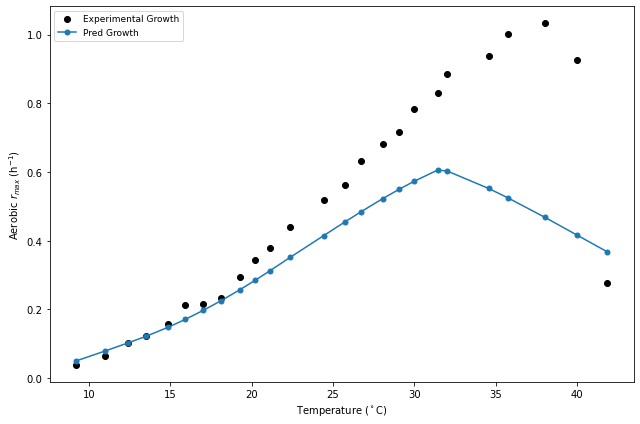

In [5]:
plt.figure(figsize=(9, 6))
plt.scatter(dfae_batch.index,dfae_batch['r'].values,label='Experimental Growth',color='k')
plt.plot(dfae_batch.index,rae['growth'],markersize=5,marker='o',label='Pred Growth')
#plt.plot(dfae_batch.index,rae['glucose'],markersize=5,marker='o',label='Glucose')
#plt.plot(dfae_batch.index,rae['oxygen'],markersize=5,marker='o',label='Oxygen')
plt.xlabel('Temperature ($^\circ$C)')
#plt.ylabel('Specific growth rate (h$^{-1}$)')
plt.ylabel('Aerobic $r_{max}$ (h$^{-1}$)')

plt.legend(fontsize=9,loc='upper left')
plt.tight_layout()
#plt.savefig('../results/presentation22.png')
plt.show()

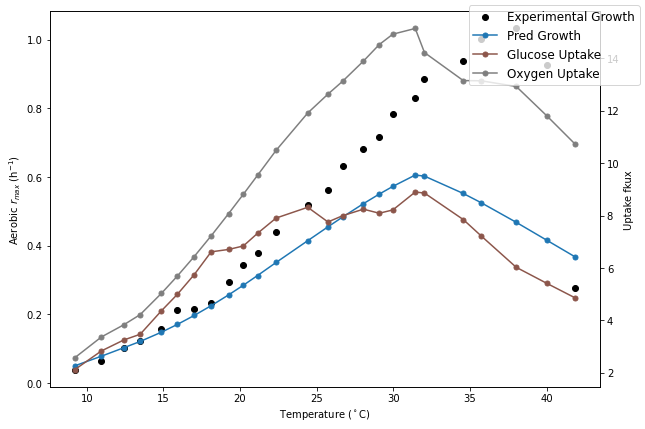

In [6]:
# Initializing the figure and dual y axes
fig, ax1 = plt.subplots(figsize=(9, 6))
ax2 = ax1.twinx()

ax1.scatter(dfae_batch.index,dfae_batch['r'].values,label='Experimental Growth',color='k')
ax1.plot(dfae_batch.index,rae['growth'],markersize=5,marker='o',label='Pred Growth')

ax2.plot(dfae_batch.index,rae['glucose'],markersize=5,marker='o',label='Glucose Uptake', color='tab:brown')
ax2.plot(dfae_batch.index,rae['oxygen'],markersize=5,marker='o',label='Oxygen Uptake', color='tab:gray')

ax1.set_xlabel("Temperature ($^\circ$C)")
ax1.set_ylabel("Aerobic $r_{max}$ (h$^{-1}$)")

ax2.set_ylabel("Uptake fkux")

fig.legend(fontsize=12)
fig.tight_layout()

#fig.savefig('../results/ALlinOne22.png')

In [7]:
sum(abs(rae['growth'] - dfae_batch['r'].values) > 0.1) ==0

False